In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



In [3]:
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        
    def forward(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        h = torch.bernoulli(h_prob)
        return h, h_prob

    def backward(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        v = torch.bernoulli(v_prob)
        return v, v_prob

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.v_bias)
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.W) + self.h_bias)), dim=1)
        return -hidden_term - vbias_term


In [4]:
visible_units = 28 * 28  
hidden_units = 256      
learning_rate = 0.1
batch_size = 64
num_epochs = 10


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


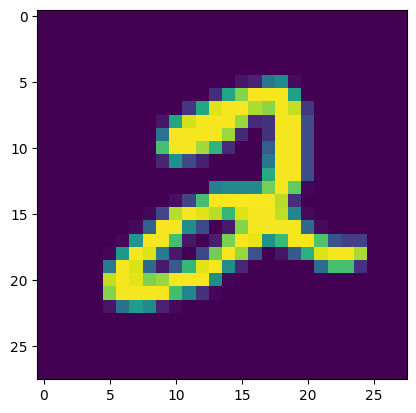

In [6]:
import matplotlib.pyplot as plt

import numpy as np
plt.imshow(train_dataset.data[5].numpy())


In [7]:
rbm = RBM(visible_units, hidden_units)

print("Weights:")
print(rbm.W)

optimizer = optim.SGD(rbm.parameters(), lr=learning_rate)

Weights:
Parameter containing:
tensor([[-4.0847e-03,  7.0607e-05, -2.9973e-01,  ..., -5.8904e-02,
          4.0739e-02,  8.2123e-02],
        [-1.5838e-01,  3.7603e-02,  3.1242e-02,  ...,  3.4509e-02,
          7.7390e-02, -5.8318e-02],
        [-3.0921e-02,  2.2523e-01, -1.1387e-02,  ..., -7.3872e-02,
         -1.8319e-01, -5.8316e-03],
        ...,
        [ 8.8831e-02, -2.1917e-02, -2.8935e-02,  ...,  2.1324e-01,
         -1.1016e-01,  6.2968e-02],
        [ 4.8023e-02,  5.9098e-02, -4.6504e-03,  ...,  5.8420e-02,
          3.7074e-02, -1.0914e-02],
        [ 2.5085e-01, -4.1477e-02,  2.5520e-02,  ...,  1.4149e-01,
          4.7532e-02, -1.2851e-01]], requires_grad=True)


In [8]:
reconstruction_errors = []

for epoch in range(num_epochs):
    for data,_ in train_loader:
        data = data.view(-1, visible_units)

        k = 1 
        vk = data.clone().detach()
        for _ in range(k):
            _, hk_prob = rbm.forward(vk)
            hk = torch.bernoulli(hk_prob)
            _, vk_prob = rbm.backward(hk)
            vk = torch.bernoulli(vk_prob)

        
        reconstructed_data, _ = rbm.backward(hk_prob)
        reconstruction_error = torch.mean((data - reconstructed_data) ** 2).item()
        reconstruction_errors.append(reconstruction_error)
        

        ph_prob = torch.sigmoid(torch.matmul(data, rbm.W) + rbm.h_bias)
        ph = torch.bernoulli(ph_prob)
        nv, nv_prob = rbm.backward(ph)
        rbm.W.grad = torch.matmul(data.t(), ph) - torch.matmul(nv.t(), ph)
        rbm.v_bias.grad = torch.sum(data - nv, dim=0)
        rbm.h_bias.grad = torch.sum(ph - ph_prob, dim=0)

        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1}/{num_epochs}")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [9]:
print("Updated Weights:")
print(rbm.W)


Updated Weights:
Parameter containing:
tensor([[59990.8555, 59990.5586, 59989.5625,  ..., 59990.1016, 59990.1992,
         59990.9414],
        [59988.7031, 59988.8984, 59988.6914,  ..., 59988.9961, 59989.0391,
         59988.9023],
        [59991.1289, 59991.2852, 59989.4492,  ..., 59989.6875, 59989.4805,
         59990.5547],
        ...,
        [59991.4492, 59991.0391, 59989.7344,  ..., 59990.8750, 59989.6523,
         59991.2227],
        [59990.3086, 59990.3203, 59989.2578,  ..., 59989.9219, 59989.3984,
         59990.2500],
        [59991.2109, 59991.3164, 59989.7891,  ..., 59990.2031, 59989.9102,
         59990.8320]], requires_grad=True)


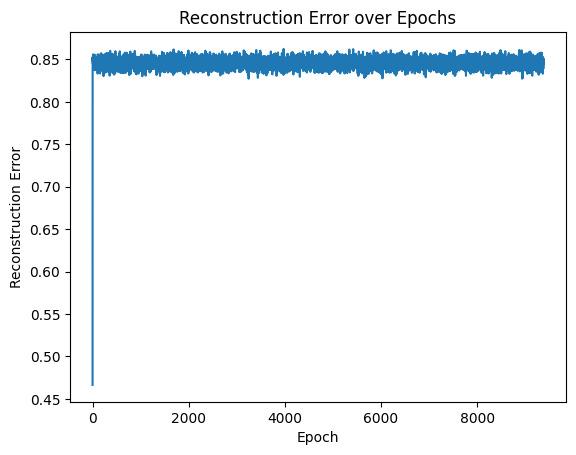

In [11]:

import matplotlib.pyplot as plt

plt.plot(range(len(reconstruction_errors)), reconstruction_errors)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over Epochs')
plt.show()